In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

2025-03-29 17:44:00.046163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Function to convert timedelta to years (approximate)
def timedelta_to_years(delta):
    total_days = delta.days + (delta.seconds / (24 * 3600))
    years = total_days / 365.2425
    return years

# Function to convert timedelta to total days (float)
def timedelta_to_days(delta):
    total_days = delta.days + (delta.seconds / (24 * 3600))
    return total_days

In [3]:
# 1. Load Data

# Load the datasets (assuming they are in the same directory or adjust paths)
df_adm = pd.read_csv('gs://msai/aih/ADMISSIONS.csv.gz') 
df_pat = pd.read_csv('gs://msai/aih/PATIENTS.csv.gz') 
df_diag = pd.read_csv('gs://msai/aih/DIAGNOSES_ICD.csv.gz') 
df_icu = pd.read_csv('gs://msai/aih/ICUSTAYS.csv.gz') 

# 2. Feature Engineering (Adapt for Mortality and LOS)

# a. Admissions Data:
# Convert admission and discharge times to datetime
df_adm['ADMITTIME'] = pd.to_datetime(df_adm['ADMITTIME']) 
df_adm['DISCHTIME'] = pd.to_datetime(df_adm['DISCHTIME']) 

# Calculate Length of Stay (LOS)
df_adm['LOS'] = (df_adm['DISCHTIME'].dt.date - df_adm['ADMITTIME'].dt.date).apply(timedelta_to_days)

# b. Create Target Variables: In-Hospital Mortality and LOS
# Mortality target
df_adm['MORTALITY'] = df_adm['HOSPITAL_EXPIRE_FLAG'] 

# c. Patient Demographics (from PATIENTS table):
df_pat = df_pat[['SUBJECT_ID', 'GENDER', 'DOB']]
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

# Calculate age at admission
df_adm = pd.merge(df_adm, df_pat, on='SUBJECT_ID', how='inner')

df_adm['ADMITTIME_DATE'] = pd.to_datetime(df_adm['ADMITTIME']).dt.date
df_adm['ADMITTIME_DATE'] = pd.to_datetime(df_adm['ADMITTIME_DATE'])
df_adm['age'] = (df_adm['ADMITTIME_DATE'].dt.date - df_adm['DOB'].dt.date).apply(timedelta_to_years)

# d. Diagnoses Data:
# Process ICD-9 codes (similar to the provided code)
df_diag['recode'] = df_diag['ICD9_CODE']
df_diag['recode'] = df_diag['recode'][~df_diag['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diag['recode'].fillna(value='999', inplace=True)
df_diag['recode'] = df_diag['recode'].str.slice(start=0, stop=3, step=1)
df_diag['recode'] = df_diag['recode'].astype(int)

# Define ICD-9 code ranges and categories
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680),
               (680, 710), (710, 740), (740, 760), (760, 780), (780, 800),
               (800, 1000), (1000, 2000)] 

diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

for num, cat_range in enumerate(icd9_ranges):
    df_diag['recode'] = np.where(df_diag['recode'].between(cat_range[0], cat_range[1]),
                                 num, df_diag['recode'])

df_diag['cat'] = df_diag['recode'].replace(diag_dict)

# Create a list of diagnoses for each admission
hadm_list = df_diag.groupby('HADM_ID')['cat'].apply(list).reset_index() 

# Convert diagnoses list into a hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer") 




In [4]:
# Merge diagnoses with the main admissions dataframe
df_adm_merged = df_adm.merge(hadm_item, how='inner', on='HADM_ID')

# e. ICU Stays Data:
# Process ICU stay information
df_icu['FIRST_CAREUNIT'] = df_icu['FIRST_CAREUNIT'].replace(
    {'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU', 'SICU': 'ICU', 'TSICU': 'ICU'}) 

icu_list = df_icu.groupby('HADM_ID')['FIRST_CAREUNIT'].apply(list).reset_index() 
icu_item = pd.get_dummies(icu_list['FIRST_CAREUNIT'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")

# Merge ICU data with the main dataframe
df_adm_merged = df_adm_merged.merge(icu_item, how='outer', on='HADM_ID')

df_adm_merged['ICU'] = df_adm_merged['ICU'].fillna(value=0)

In [5]:
# 3. Data Cleaning and Preprocessing

# Convert categorical variables to dummy variables
categorical_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER']
df_adm_merged_with_dummies = pd.get_dummies(df_adm_merged, columns=categorical_cols, prefix=['ADM', 'INS', 'REL', 'MAR', 'ETH', 'GENDER'], dtype=int)

df_adm_merged_with_dummies = df_adm_merged_with_dummies[(df_adm_merged_with_dummies['MORTALITY']>=0)&(df_adm_merged_with_dummies['MORTALITY']<=1)]
# 4. Prepare Data for Modeling

# Separate target variables (Mortality and LOS) and features
target_mortality = df_adm_merged_with_dummies['MORTALITY']


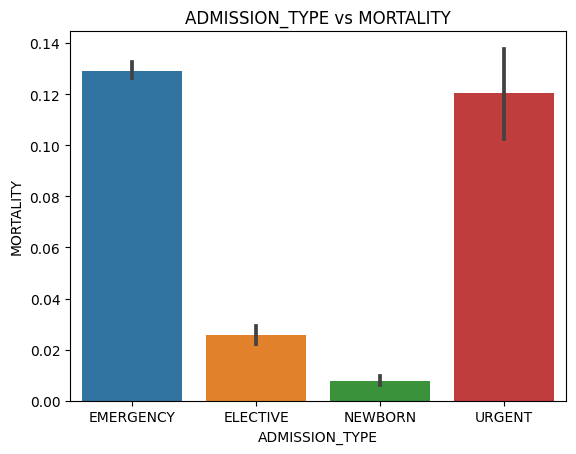

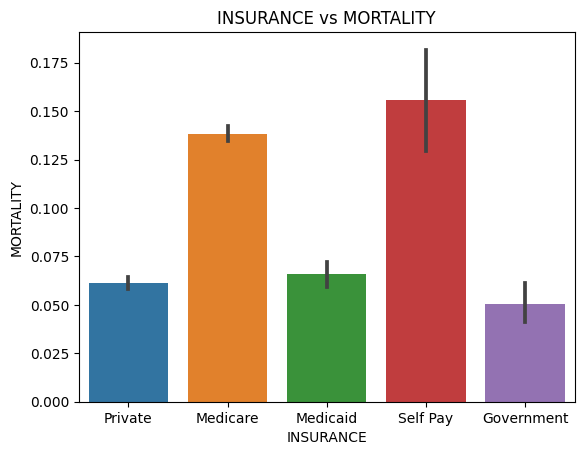

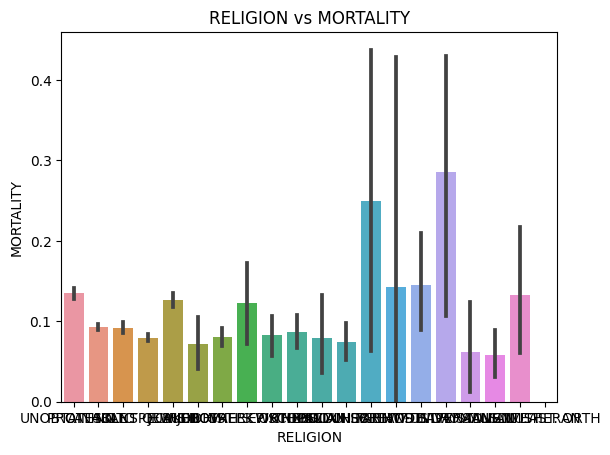

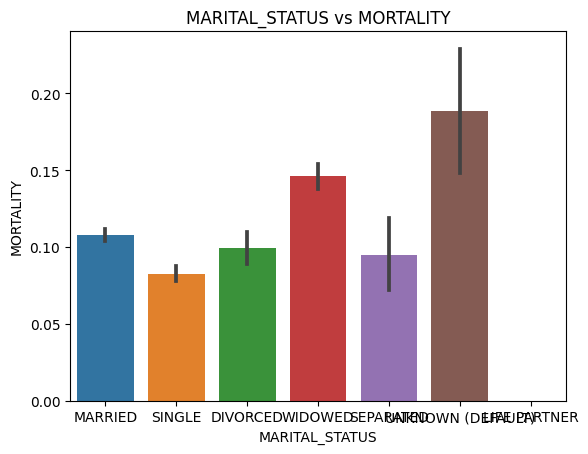

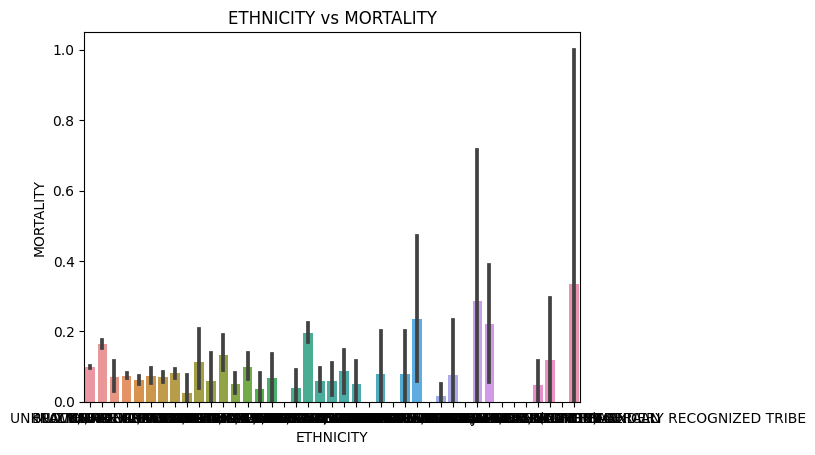

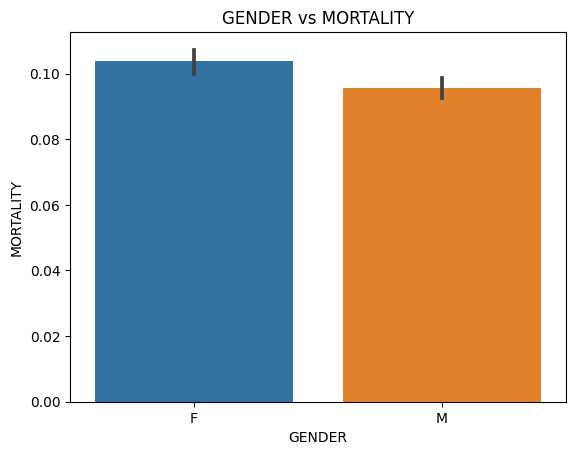

In [6]:
for column in categorical_cols:
    plt.figure()  # Create a new figure for each plot
    sns.barplot(x=df_adm_merged[column], y=df_adm_merged['MORTALITY'], data=df_adm_merged)
    plt.title(f'{column} vs MORTALITY')
    plt.xlabel(column)
    plt.ylabel('MORTALITY')
    plt.show()

In [7]:
features = df_adm_merged_with_dummies.drop(columns=['MORTALITY', 'LOS', 'ADMITTIME_DATE','DOB','EDREGTIME','DEATHTIME','DISCHTIME','ADMITTIME','ROW_ID','SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','HADM_ID','ICU'], errors='ignore')

features = features.select_dtypes(include=np.number)

# Scale numerical features (important for neural networks)
# numerical_cols = features.columns  # Add other numerical columns if needed
# scaler = MinMaxScaler()
# features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

In [8]:
# finalise relevant columns based on correlation cutoff
col_to_filter = df_adm_merged_with_dummies.select_dtypes(include=np.number).corr()[['MORTALITY']]
col_to_filter
col_to_filter[(col_to_filter['MORTALITY']>.005)].index

Index(['HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'MORTALITY', 'age',
       'blood', 'circulatory', 'digestive', 'endocrine', 'genitourinary',
       'infectious', 'injury', 'misc', 'neoplasms', 'nervous', 'respiratory',
       'skin', 'ICU', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Medicare',
       'INS_Self Pay', 'REL_BAPTIST', 'REL_HEBREW', 'REL_JEWISH',
       'REL_UNITARIAN-UNIVERSALIST', 'REL_UNOBTAINABLE', 'MAR_MARRIED',
       'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED',
       'ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ETH_ASIAN - CAMBODIAN', 'ETH_ASIAN - JAPANESE',
       'ETH_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ETH_UNABLE TO OBTAIN',
       'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE - RUSSIAN', 'GENDER_F'],
      dtype='object')

In [9]:
target_var = 'MORTALITY'
feature_list=[ 'age',
       'blood', 'circulatory', 'digestive', 'endocrine', 'genitourinary',
       'infectious', 'injury', 'misc', 'neoplasms', 'nervous', 'respiratory',
       'skin', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Medicare',
       'INS_Self Pay', 'REL_BAPTIST', 'REL_HEBREW', 'REL_JEWISH',
       'REL_UNITARIAN-UNIVERSALIST', 'REL_UNOBTAINABLE', 'MAR_MARRIED',
       'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED',
       'ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ETH_ASIAN - CAMBODIAN', 'ETH_ASIAN - JAPANESE',
       'ETH_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ETH_UNABLE TO OBTAIN',
       'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE - RUSSIAN', 'GENDER_F','LOS']

In [10]:
age_cutoff = df_adm_merged_with_dummies[['age']].quantile([.9]).values[0][0]

In [11]:
mean_age_after_cutoff = df_adm_merged_with_dummies[df_adm_merged_with_dummies['age']< age_cutoff]['age'].mean()

In [12]:
final_model_input = df_adm_merged_with_dummies[feature_list+[target_var]].dropna(subset=feature_list)

# final_model_input.iloc[final_model_input['age']>=age_cutoff] = mean_age_after_cutoff
final_model_input.loc[final_model_input['age']>=age_cutoff, 'age'] = mean_age_after_cutoff

features = final_model_input[feature_list]
target_mortality = final_model_input[target_var]

# .fillna(features.mean())

In [13]:
final_model_input.groupby(target_var).count()

,age,blood,circulatory,digestive,endocrine,genitourinary,infectious,injury,misc,neoplasms,...,MAR_WIDOWED,ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETH_ASIAN - CAMBODIAN,ETH_ASIAN - JAPANESE,ETH_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETH_UNABLE TO OBTAIN,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE - RUSSIAN,GENDER_F,LOS
MORTALITY,,,,,,,,,,,,,,,,,,,,,
0,53122,53122,53122,53122,53122,53122,53122,53122,53122,53122,...,53122,53122,53122,53122,53122,53122,53122,53122,53122,53122
1,5854,5854,5854,5854,5854,5854,5854,5854,5854,5854,...,5854,5854,5854,5854,5854,5854,5854,5854,5854,5854


In [14]:
features.quantile([0.5, 0.75])

,age,blood,circulatory,digestive,endocrine,genitourinary,infectious,injury,misc,neoplasms,...,MAR_WIDOWED,ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETH_ASIAN - CAMBODIAN,ETH_ASIAN - JAPANESE,ETH_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETH_UNABLE TO OBTAIN,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE - RUSSIAN,GENDER_F,LOS
0.50,55.823186,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
0.75,70.052773,1.0,4.0,1.0,2.0,1.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0


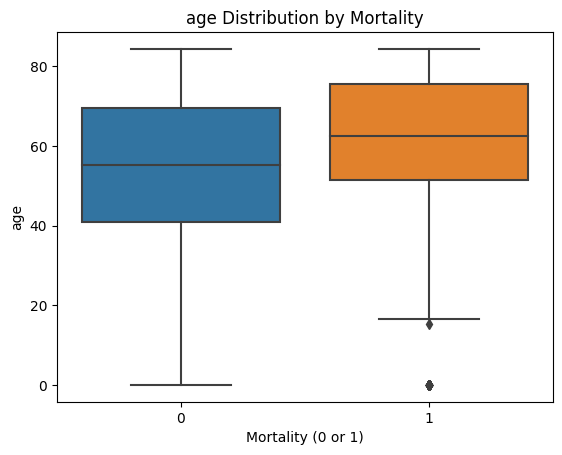

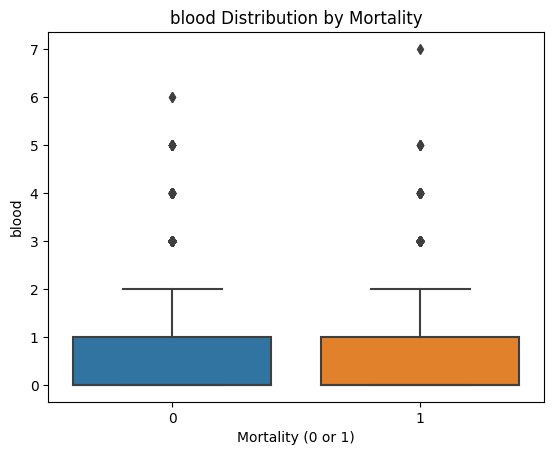

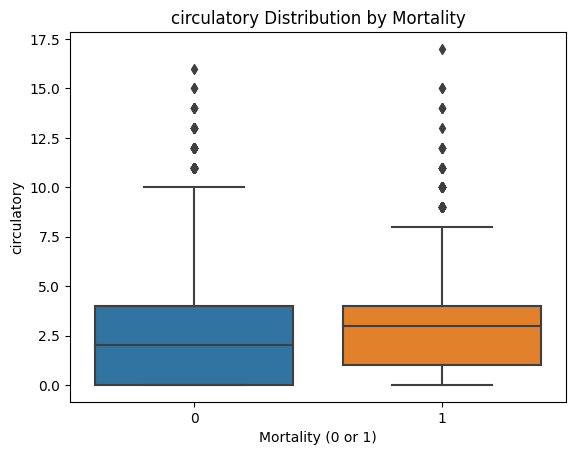

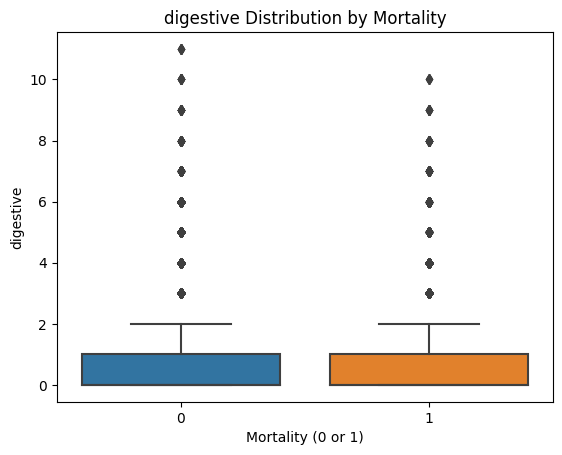

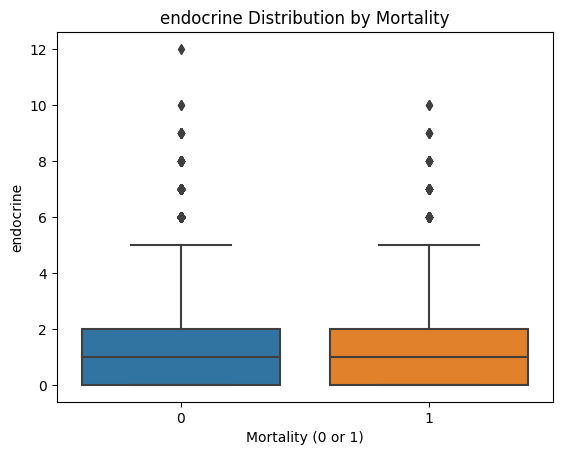

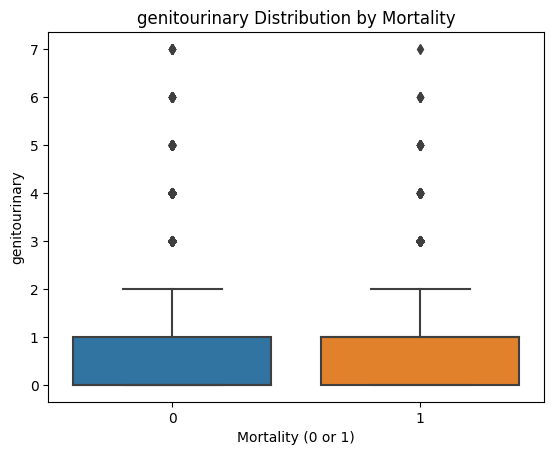

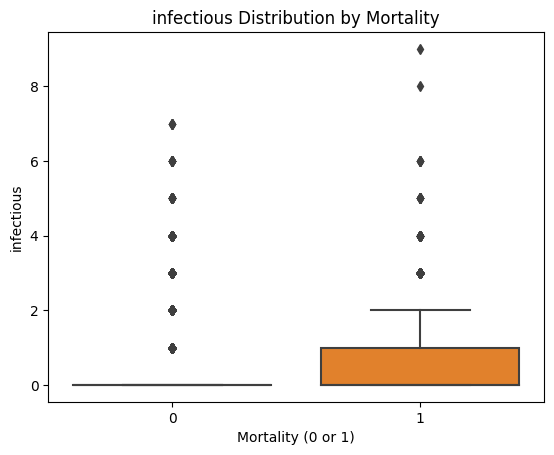

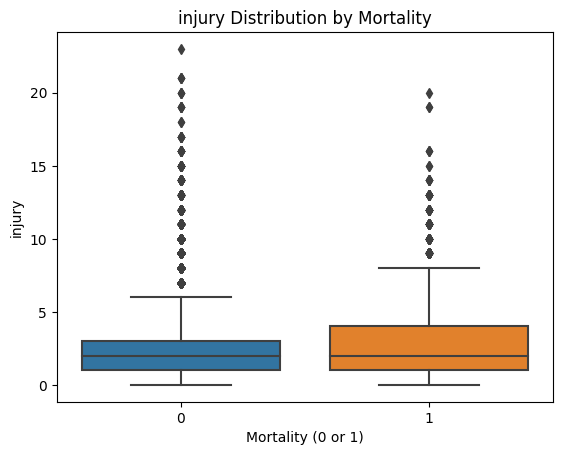

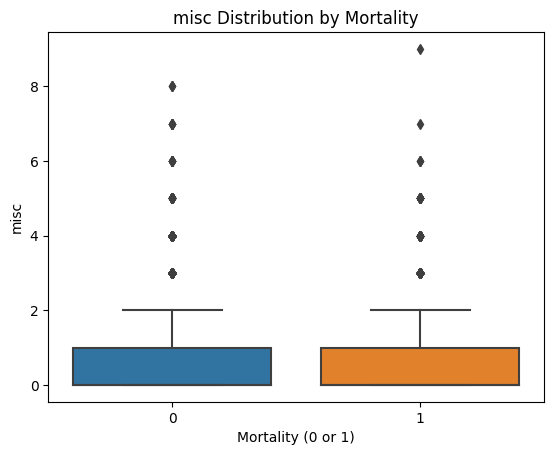

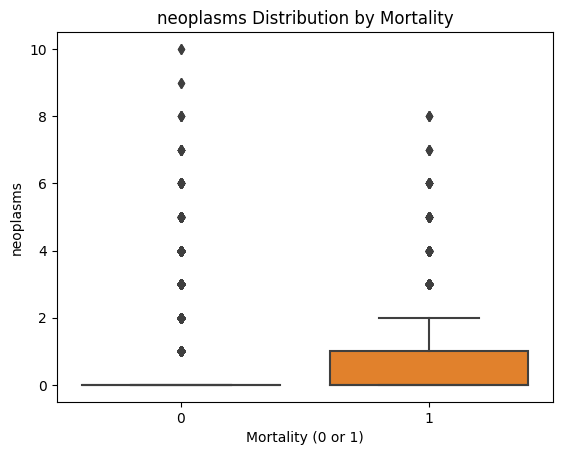

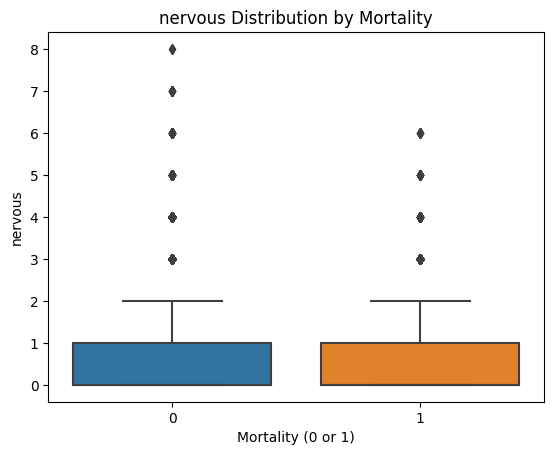

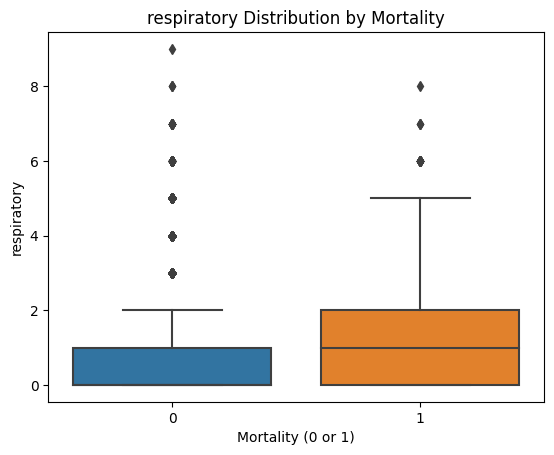

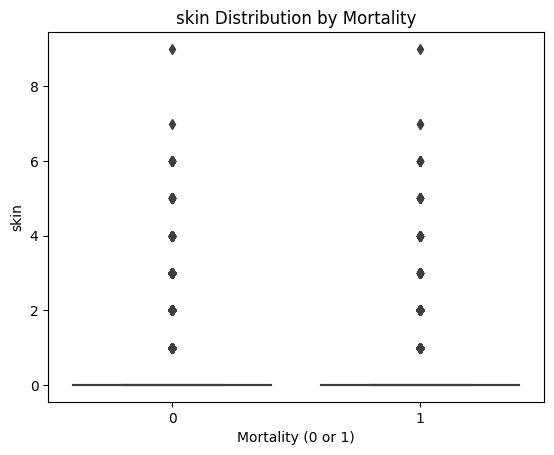

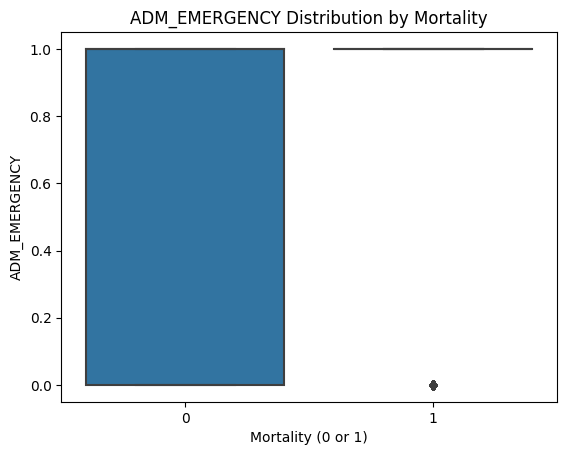

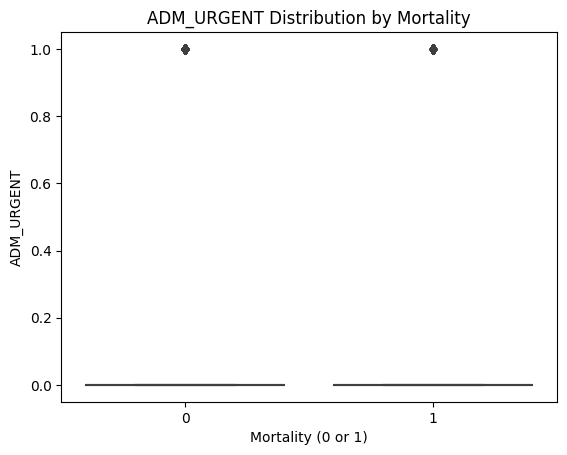

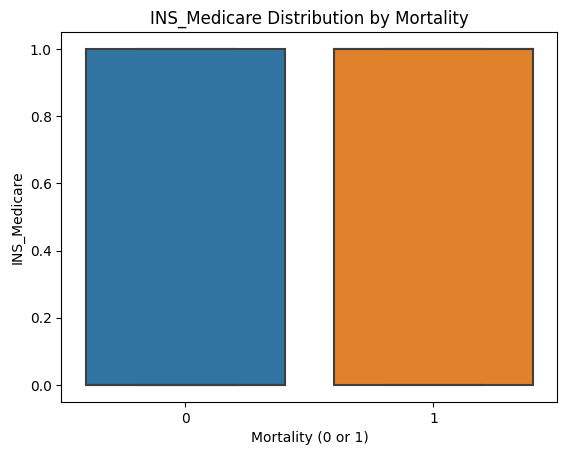

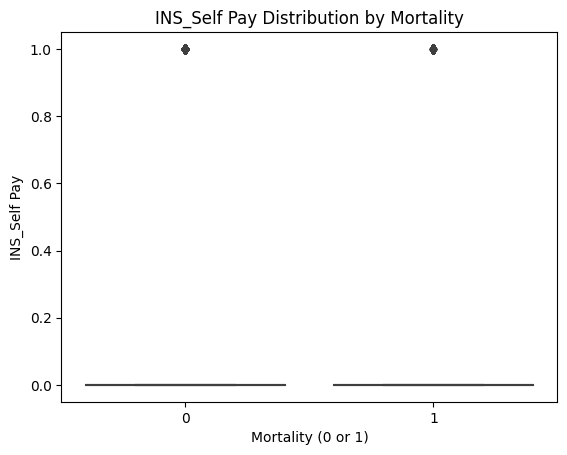

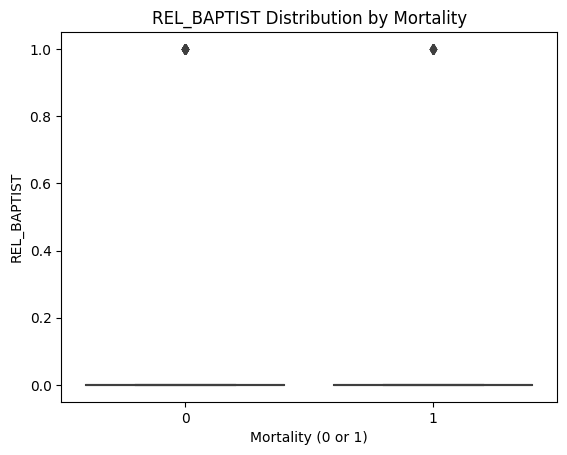

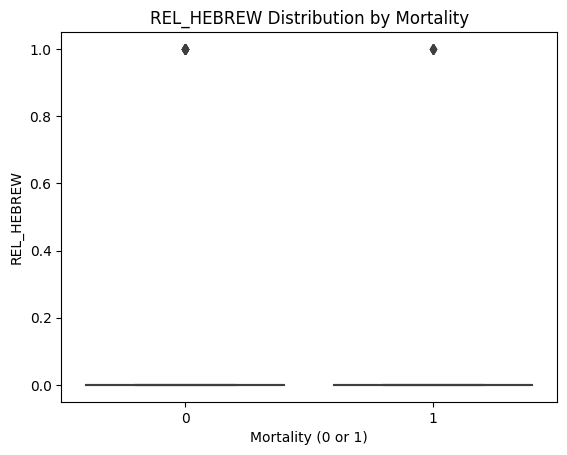

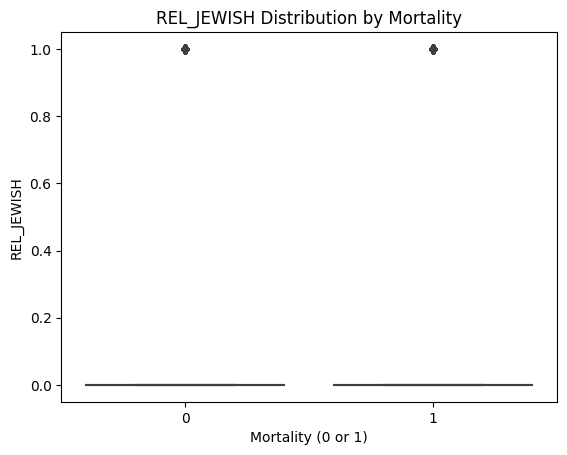

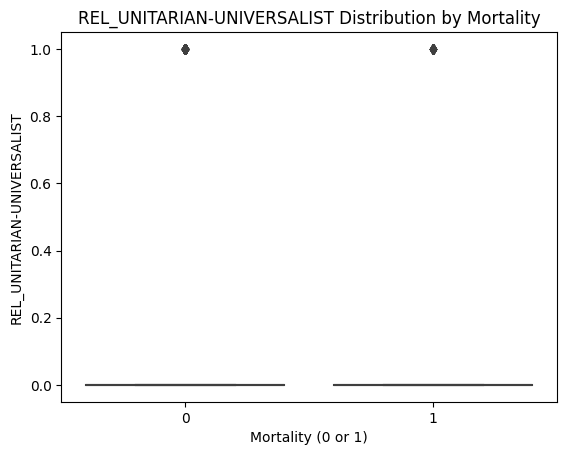

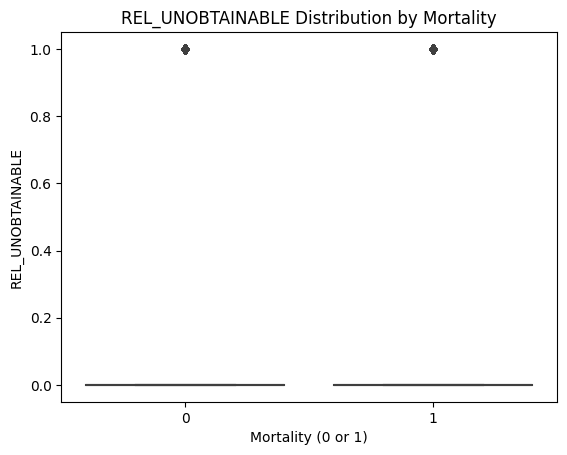

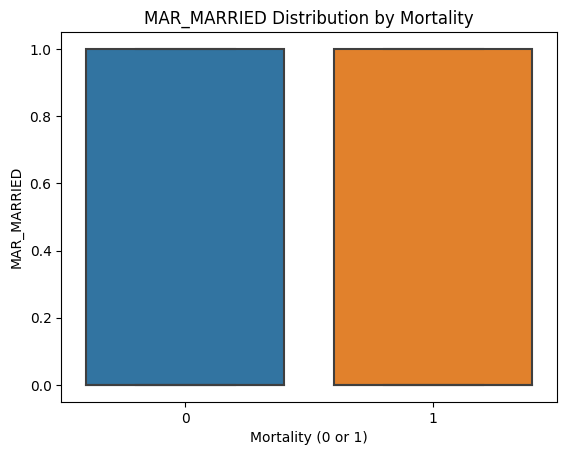

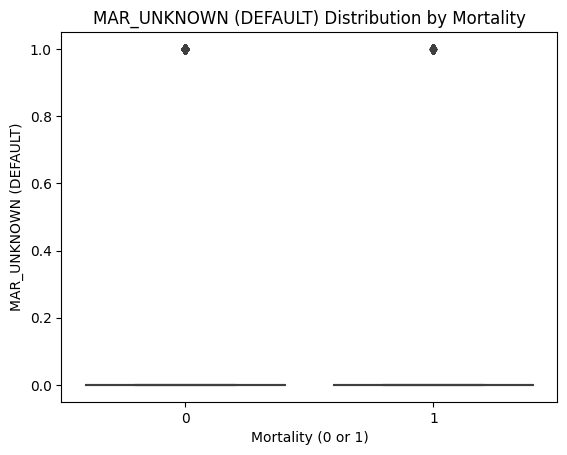

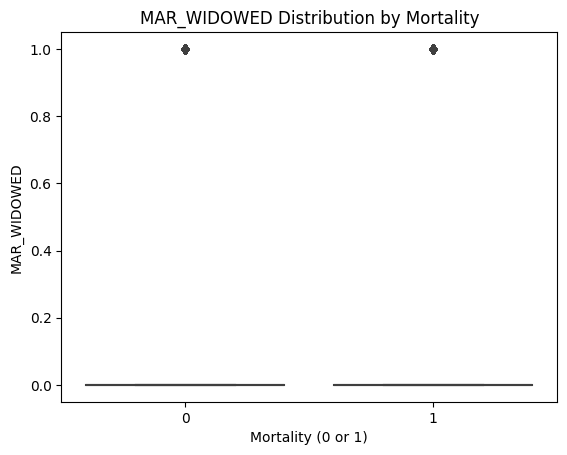

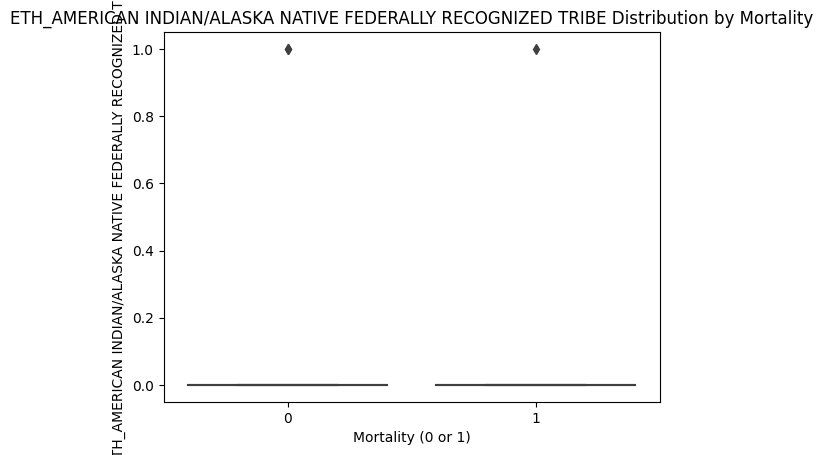

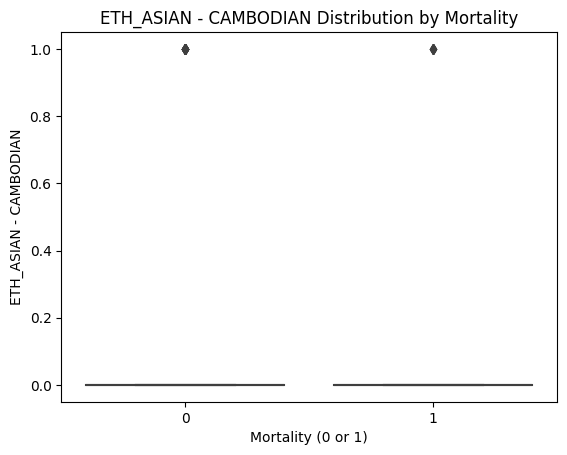

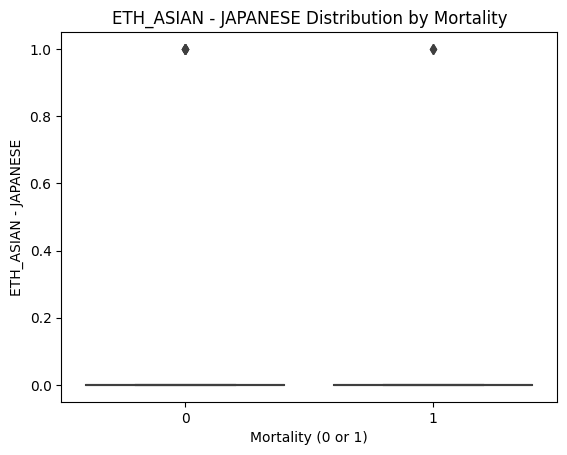

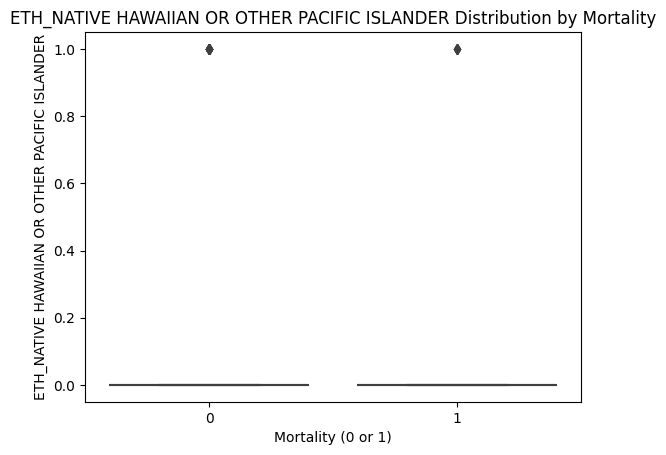

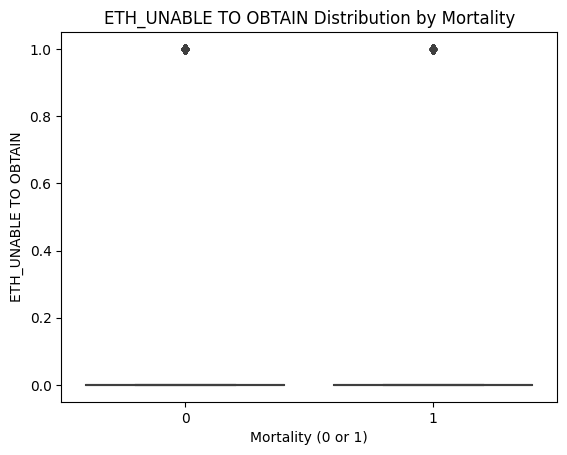

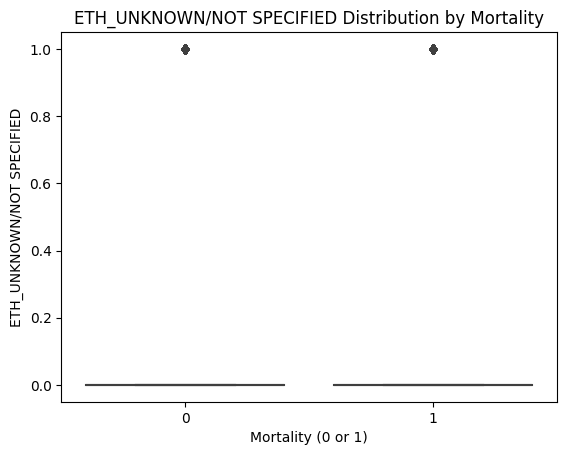

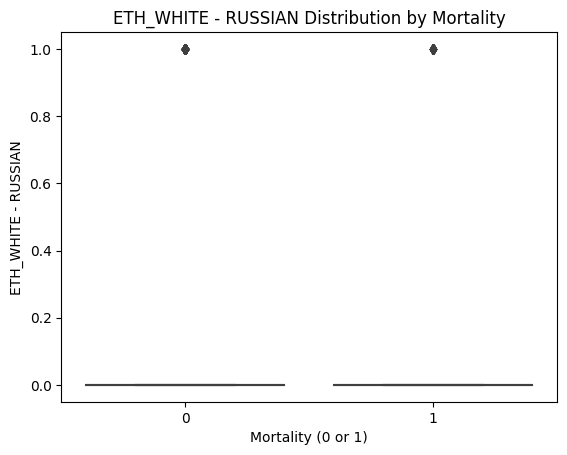

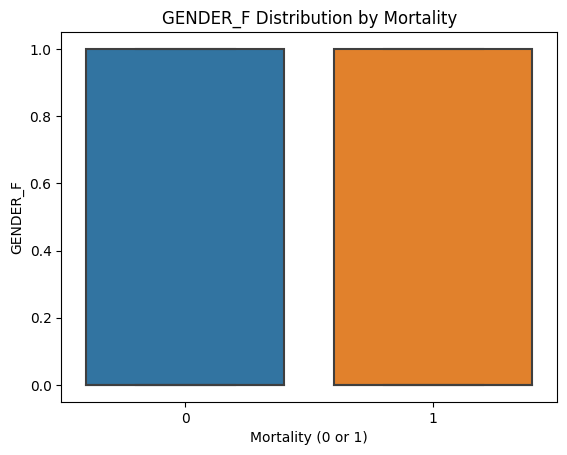

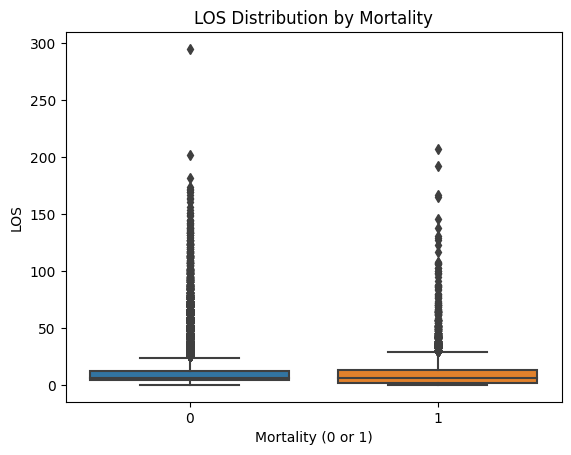

In [15]:
# Plot final list of variables before scaling

for column in feature_list:
    plt.figure()
    sns.boxplot(x='MORTALITY', y=column, data=final_model_input)  # Use boxplot
    plt.title(f'{column} Distribution by Mortality')
    plt.xlabel('Mortality (0 or 1)')
    plt.ylabel(column)
    plt.show()

In [16]:
scaler = MinMaxScaler()
features[feature_list] = scaler.fit_transform(features[feature_list])

/tmp/ipykernel_1/1584923450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[feature_list] = scaler.fit_transform(features[feature_list])


In [17]:
features.quantile([0.5, 0.75])

,age,blood,circulatory,digestive,endocrine,genitourinary,infectious,injury,misc,neoplasms,...,MAR_WIDOWED,ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETH_ASIAN - CAMBODIAN,ETH_ASIAN - JAPANESE,ETH_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETH_UNABLE TO OBTAIN,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE - RUSSIAN,GENDER_F,LOS
0.50,0.661830,0.000000,0.117647,0.000000,0.083333,0.000000,0.0,0.086957,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020339
0.75,0.830534,0.142857,0.235294,0.090909,0.166667,0.142857,0.0,0.130435,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.040678


In [18]:
# 5. Split Data into Training and Testing Sets
X_train, X_test, y_train_mortality, y_test_mortality = train_test_split(
    features, target_mortality, test_size=0.2, random_state=42)


In [19]:
# 6. Machine Learning Models

# a. Logistic Regression (for Mortality)
# logreg = LogisticRegression(random_state=42, solver='liblinear')
# logreg.fit(X_train, y_train_mortality)
# y_pred_mortality_logreg = logreg.predict(X_test)

# b. Gradient Boosting Regressor (for LOS)
gbr_mor = GradientBoostingRegressor(random_state=42)
gbr_mor.fit(X_train, y_train_mortality)
y_pred_mor_gbr = gbr_mor.predict(X_test)

In [20]:
# 7. Deep Learning Model (Neural Network)

# Define a simple neural network for multitask prediction
def build_model(input_shape):
    input_layer = keras.Input(shape=(input_shape,))
    dense1 = layers.Dense(128, activation='relu')(input_layer)
    dense2 = layers.Dense(64, activation='relu')(dense1)
    dense3 = layers.Dense(32, activation='relu')(dense2)
    # Output for mortality (classification)
    output_mortality = layers.Dense(1, activation='sigmoid', name='mortality_out')(dense3)
    model = keras.Model(inputs=input_layer, outputs=[output_mortality])
    return model

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model = build_model(X_train.shape[1])

# Compile the model
model.compile(optimizer=optimizer,
              loss={'mortality_out': 'binary_crossentropy'},
              metrics={'mortality_out': 'accuracy'})

# Train the model
model.fit(X_train, {'mortality_out': y_train_mortality}, epochs=10, batch_size=32)
y_pred_mortality_nn = model.predict(X_test)



2025-03-29 17:45:43.715620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-29 17:45:43.719130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-29 17:45:47.988201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2025-03-29 17:45:56.523859: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc548cb0150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-29 17:45:56.523917: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-29 17:45:56.523930: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-03-29 17:45:57.948008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-29 17:45:59.635345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906
2025-03-29 17:46:04.367128: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1475/1475 [==============================] - 18s 3ms/step - loss: 0.2866 - accuracy: 0.9013
Epoch 2/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2772 - accuracy: 0.9013
Epoch 3/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2728 - accuracy: 0.9013
Epoch 4/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2685 - accuracy: 0.9015
Epoch 5/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2646 - accuracy: 0.9016
Epoch 6/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2608 - accuracy: 0.9019
Epoch 7/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2577 - accuracy: 0.9030
Epoch 8/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2540 - accuracy: 0.9038
Epoch 9/10
1475/1475 [==============================] - 5s 3ms/step - loss: 0.2500 - accuracy: 0.9060
Epoch 10/10
369/369 [==============================] - 1s 1ms/step



--- Gradient Boosting Regressor (Mortality) ---
R-squared: 0.21822370396821822
AUC-ROC: 0.8495861505352224
Mean Squared Error: 0.07133352797865437

--- Neural Network (Mortality) ---
R-squared: 0.21822370396821822
AUC-ROC: 0.8472072092223908
Mean Squared Error: 0.07360998454323156

--- Feature Importance (Gradient Boosting Regressor for Mortality) ---
               importance
LOS              0.288390
respiratory      0.171597
age              0.104399
infectious       0.072218
ADM_EMERGENCY    0.059824
neoplasms        0.048562
misc             0.047987
genitourinary    0.047058
circulatory      0.026863
digestive        0.023022


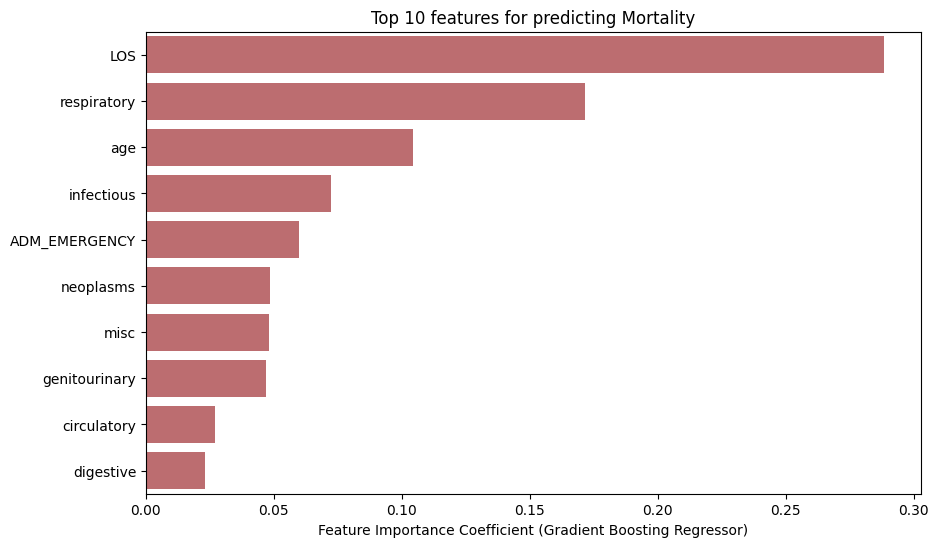

In [21]:
# 8. Model Evaluation

print("\n--- Gradient Boosting Regressor (Mortality) ---")
print("R-squared:", r2_score(y_test_mortality, y_pred_mor_gbr))
print("AUC-ROC:", roc_auc_score(y_test_mortality, y_pred_mor_gbr))
print("Mean Squared Error:", mean_squared_error(y_test_mortality, y_pred_mor_gbr))


print("\n--- Neural Network (Mortality) ---")
print("R-squared:", r2_score(y_test_mortality, y_pred_mor_gbr))
print("AUC-ROC:", roc_auc_score(y_test_mortality, y_pred_mortality_nn))
print("Mean Squared Error:", mean_squared_error(y_test_mortality, y_pred_mortality_nn))
# print("Accuracy:", accuracy_score(y_test_mortality, y_pred_mortality_nn))

# 9. Feature Importance (Example with Gradient Boosting)

feature_imp_gbr = pd.DataFrame(gbr_mor.feature_importances_,
                             index=X_train.columns,
                             columns=['importance']).sort_values('importance', ascending=False)

print("\n--- Feature Importance (Gradient Boosting Regressor for Mortality) ---")
print(feature_imp_gbr.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp_gbr['importance'].values[0:10],
            y=feature_imp_gbr.index[0:10],
            orient='h',
            color='#c44e52',
            alpha=0.9)
plt.title("Top 10 features for predicting Mortality")
plt.xlabel('Feature Importance Coefficient (Gradient Boosting Regressor)')
plt.show()